# Muthoot Finance

In [1]:
# Load necessary libraries
import sys
import glob
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import gensim
import spacy
import numpy as np
import tqdm.notebook as tqdm
from pprint import pprint
import pickle
import plotly.express as px
import pyLDAvis

sys.path.append('/Users/pushkar/Documents/projects/fin_comp/comp/docs')

import utils.helper
from utils.helper import Processor
import importlib
importlib.reload(utils.helper)

<module 'utils.helper' from '/Users/pushkar/Documents/projects/fin_comp/comp/docs/utils/helper.py'>

In [2]:
# Load data
df = pd.read_csv('./../../data/nbfc/muthoot_finance/muthoot_finance.csv')

In [3]:
# Know the shape of the loaded data
df.shape

(8198, 27)

## Preprocessing

In [4]:
processor = Processor('./../../data/config.json')

In [5]:
# Preprocess the data
pre_df, post_df = processor.preprocess(df)

In [6]:
# Create dictionaries
pre_id2word = gensim.corpora.Dictionary(pre_df['bigram'].values.tolist())
post_id2word = gensim.corpora.Dictionary(post_df['bigram'].values.tolist())

In [7]:
# Create corpus
pre_corpus = [pre_id2word.doc2bow(text) for text in pre_df['bigram'].values.tolist()]
post_corpus = [post_id2word.doc2bow(text) for text in post_df['bigram'].values.tolist()]

## Base Model

### Training

In [8]:
pre_lda_model = gensim.models.LdaMulticore(corpus=pre_corpus,
                                        id2word=pre_id2word,
                                        num_topics=10,
                                        random_state=42,
                                        chunksize=100,
                                        passes=10,
                                        per_word_topics=True)

In [9]:
pprint(pre_lda_model.print_topics())
pre_doc_lda = pre_lda_model[pre_corpus]

[(0,
  '0.012*"holding" + 0.012*"results" + 0.010*"company_ka" + 0.009*"buy" + '
  '0.008*"cmp" + 0.008*"employees_bad" + 0.008*"taking_money" + 0.008*"sl" + '
  '0.007*"repeat" + 0.007*"target"'),
 (1,
  '0.016*"today" + 0.014*"share" + 0.014*"gold" + 0.011*"high" + '
  '0.010*"market" + 0.010*"bank" + 0.010*"india" + 0.009*"industries" + '
  '0.008*"customer" + 0.008*"company"'),
 (2,
  '0.015*"gold_loan" + 0.013*"kerala" + 0.010*"gold" + 0.008*"md" + '
  '0.008*"entry" + 0.006*"company" + 0.006*"promoter" + 0.006*"final" + '
  '0.006*"indian" + 0.006*"paisa"'),
 (3,
  '0.010*"office" + 0.009*"police" + 0.008*"department" + 0.006*"volume" + '
  '0.006*"cash" + 0.005*"stop" + 0.005*"near" + 0.005*"enter" + '
  '0.005*"markets" + 0.005*"like"'),
 (4,
  '0.011*"loan" + 0.010*"th" + 0.010*"visit" + 0.009*"details" + 0.008*"share" '
  '+ 0.007*"money" + 0.007*"price" + 0.007*"received" + 0.006*"report" + '
  '0.006*"time"'),
 (5,
  '0.020*"client_india" + 0.019*"payment_sent" + 0.017*"bes

In [10]:
post_lda_model = gensim.models.LdaMulticore(corpus=post_corpus,
                                        id2word=post_id2word,
                                        num_topics=10,
                                        random_state=42,
                                        chunksize=100,
                                        passes=10,
                                        per_word_topics=True)

In [11]:
pprint(post_lda_model.print_topics())
post_doc_lda = post_lda_model[post_corpus]

[(0,
  '0.014*"loan" + 0.010*"pay" + 0.009*"rbi" + 0.009*"tradingview" + '
  '0.006*"help" + 0.006*"hello" + 0.006*"moratorium" + 0.006*"company" + '
  '0.005*"gold_loan" + 0.005*"contact"'),
 (1,
  '0.013*"stock" + 0.011*"manappuram" + 0.010*"growth" + '
  '0.009*"george_alexander" + 0.008*"strong" + 0.007*"gold" + 0.007*"md" + '
  '0.007*"gold_prices" + 0.006*"results" + 0.006*"day"'),
 (2,
  '0.013*"help" + 0.011*"gold_loan" + 0.010*"short" + 0.010*"day" + '
  '0.010*"target" + 0.009*"today" + 0.008*"profit" + 0.008*"trade" + '
  '0.006*"stock_split" + 0.006*"good"'),
 (3,
  '0.027*"gold" + 0.016*"company" + 0.016*"gold_loan" + 0.010*"good" + '
  '0.008*"high" + 0.008*"lockdown" + 0.007*"july" + 0.007*"stock" + '
  '0.006*"business" + 0.006*"positive"'),
 (4,
  '0.015*"loan" + 0.015*"gold" + 0.008*"time" + 0.008*"index" + 0.007*"home" + '
  '0.007*"story" + 0.007*"india" + 0.007*"gold_loan" + 0.007*"business" + '
  '0.006*"people"'),
 (5,
  '0.017*"view" + 0.010*"like" + 0.010*"gold

### Evaluation

In [12]:
pre_coherence_model_lda = gensim.models.CoherenceModel(model=pre_lda_model, 
                                                    texts=pre_df['bigram'].values.tolist(), 
                                                    dictionary=pre_id2word, 
                                                    coherence='u_mass')
pre_coherence_lda = pre_coherence_model_lda.get_coherence()
print('Pre-COVID Coherence Score: ', pre_coherence_lda)

Pre-COVID Coherence Score:  -15.744912208585408


In [13]:
post_coherence_model_lda = gensim.models.CoherenceModel(model=post_lda_model, 
                                                    texts=post_df['bigram'].values.tolist(), 
                                                    dictionary=post_id2word, 
                                                    coherence='u_mass')
post_coherence_lda = post_coherence_model_lda.get_coherence()
print('Post-COVID Coherence Score: ', post_coherence_lda)

Post-COVID Coherence Score:  -11.45934810638656


## Hyper-parameter tuning

### Pre-COVID

In [14]:
pre_df_result = processor.perform_hyperparameter_tuning(pre_corpus, 
                                                        pre_id2word, 
                                                        pre_df['bigram'].values.tolist(), 
                                                        "./../../data/nbfc/muthoot_finance/pre.csv")

100%|██████████| 780/780 [1:01:19<00:00,  4.72s/it]


In [15]:
# pre_df_result = pd.read_csv("./../../data/nbfc/muthoot_finance/pre.csv")

In [16]:
# Maximum coherence
pre_df_result.sort_values('Coherence', ascending=False, inplace=True)
pre_df_result.head(10)

,Validation_Set,Topics,Alpha,Beta,Coherence
88,75.0% Corpus,4,asymmetric,0.9099999999999999,-9.920580
19,75.0% Corpus,2,0.9099999999999999,symmetric,-10.748148
16,75.0% Corpus,2,0.9099999999999999,0.31,-10.769218
348,75.0% Corpus,13,0.9099999999999999,0.9099999999999999,-10.814241
708,100% Corpus,12,0.9099999999999999,0.9099999999999999,-11.067010
738,100% Corpus,13,0.9099999999999999,0.9099999999999999,-11.078182
378,75.0% Corpus,14,0.9099999999999999,0.9099999999999999,-11.152183
767,100% Corpus,14,0.9099999999999999,0.61,-11.191562
537,100% Corpus,6,asymmetric,0.61,-11.355542
0,75.0% Corpus,2,0.01,0.01,-11.372392


In [68]:
pre_ts_df = processor.create_topic_df(pre_df_result[pre_df_result['Validation_Set'] == '75.0% Corpus'], 
                                        '0.9099999999999999',
                                        '0.61')

<AxesSubplot: title={'center': 'Coherence Plot'}, xlabel='topics'>

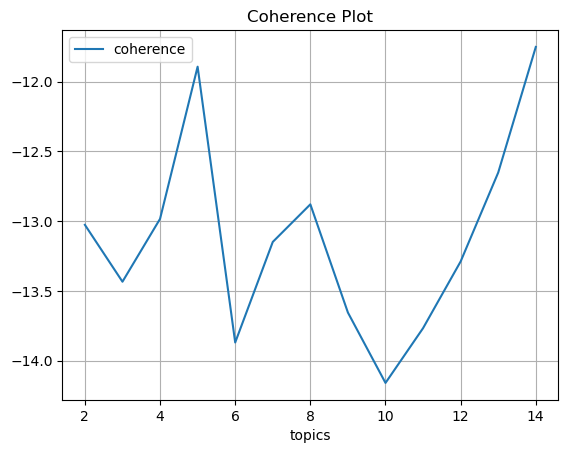

In [69]:
pre_ts_df.plot.line(x='topics', y='coherence', title='Coherence Plot', grid = True)

In [70]:
fig = px.line(pre_ts_df, x='topics', y='coherence', title='Coherence plot')
fig.show()

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



For pre-COVID period, 4 is the optimum number of topic.

In [65]:
pre_df_result[pre_df_result['Topics'] == 3].head(5)

,Validation_Set,Topics,Alpha,Beta,Coherence
437,100% Corpus,3,0.9099999999999999,0.61,-12.286530
434,100% Corpus,3,0.61,symmetric,-12.465312
423,100% Corpus,3,0.01,0.9099999999999999,-12.533150
43,75.0% Corpus,3,0.61,0.9099999999999999,-12.627928
33,75.0% Corpus,3,0.01,0.9099999999999999,-12.828603


### Post-COVID

In [21]:
post_df_result = processor.perform_hyperparameter_tuning(post_corpus, 
                                                        post_id2word, 
                                                        post_df['bigram'].values.tolist(), 
                                                        "./../../data/nbfc/muthoot_finance/post.csv")

100%|██████████| 780/780 [1:04:22<00:00,  4.95s/it]


In [22]:
# post_df_result = pd.read_csv("./../../data/nbfc/muthoot_finance/post.csv")

In [23]:
# Maximum coherence
post_df_result.sort_values('Coherence', ascending=False, inplace=True)
post_df_result.head(10)

,Validation_Set,Topics,Alpha,Beta,Coherence
419,100% Corpus,2,asymmetric,symmetric,-5.519985
416,100% Corpus,2,asymmetric,0.31,-6.026780
415,100% Corpus,2,asymmetric,0.01,-6.219622
418,100% Corpus,2,asymmetric,0.9099999999999999,-6.393891
26,75.0% Corpus,2,asymmetric,0.31,-6.518135
424,100% Corpus,3,0.01,symmetric,-6.553390
394,100% Corpus,2,0.01,symmetric,-6.785878
432,100% Corpus,3,0.61,0.61,-6.824338
417,100% Corpus,2,asymmetric,0.61,-6.854249
768,100% Corpus,14,0.9099999999999999,0.9099999999999999,-7.137814


In [35]:
post_ts_df = processor.create_topic_df(post_df_result[post_df_result['Validation_Set'] == '100% Corpus'], 
                                        'asymmetric',
                                        'symmetric')

<AxesSubplot: title={'center': 'Coherence Plot'}, xlabel='topics'>

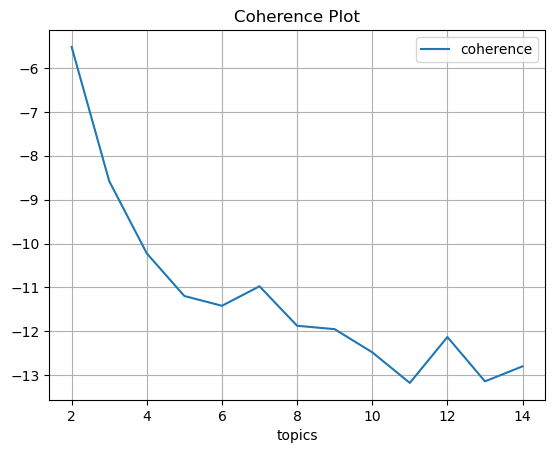

In [36]:
post_ts_df.plot.line(x='topics', y='coherence', title='Coherence Plot', grid = True)

In [37]:
fig = px.line(post_ts_df, x='topics', y='coherence', title='Coherence plot')
fig.show()

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



For the post-COVID period, the model with a number of topics equal to 2 gives the best coherence score.

In [38]:
post_df_result[(post_df_result['Topics'] == 2)].head()

,Validation_Set,Topics,Alpha,Beta,Coherence
419,100% Corpus,2,asymmetric,symmetric,-5.519985
416,100% Corpus,2,asymmetric,0.31,-6.026780
415,100% Corpus,2,asymmetric,0.01,-6.219622
418,100% Corpus,2,asymmetric,0.9099999999999999,-6.393891
26,75.0% Corpus,2,asymmetric,0.31,-6.518135


## Final Models

### Pre-COVID

In [66]:
pre_final_lda_model = gensim.models.LdaMulticore(corpus=gensim.utils.ClippedCorpus(pre_corpus, int(len(pre_corpus)*0.75)),
                                        id2word=pre_id2word,
                                        num_topics=3,
                                        random_state=100,
                                        chunksize=100,
                                        passes=10,
                                        per_word_topics=True,
                                        alpha=0.91,
                                        eta=0.61)

In [67]:
pre_final_coherence_model_lda = gensim.models.CoherenceModel(model=pre_final_lda_model, 
                                                    texts=pre_df['bigram'].values.tolist(), 
                                                    dictionary=pre_id2word, 
                                                    coherence='u_mass')
pre_final_coherence_lda = pre_final_coherence_model_lda.get_coherence()
print('Pre-COVID Coherence Score: ', pre_final_coherence_lda)

Pre-COVID Coherence Score:  -12.901625436387315


### Post-COVID

In [57]:
post_final_lda_model = gensim.models.LdaMulticore(corpus=post_corpus,
                                        id2word=post_id2word,
                                        num_topics=2,
                                        random_state=100,
                                        chunksize=100,
                                        passes=10,
                                        per_word_topics=True,
                                        alpha='asymmetric',
                                        eta=0.31)

In [58]:
post_final_coherence_model_lda = gensim.models.CoherenceModel(model=post_final_lda_model, 
                                                    texts=post_df['bigram'].values.tolist(), 
                                                    dictionary=post_id2word, 
                                                    coherence='u_mass')
post_final_coherence_lda = post_final_coherence_model_lda.get_coherence()
print('Post-COVID Coherence Score: ', post_final_coherence_lda)

Post-COVID Coherence Score:  -5.64993970572526


## Inferencing

### Pre-COVID

In [71]:
pre_df_topic_sents_keywords = processor.dominant_topics(ldamodel=pre_final_lda_model, 
                                                         corpus=pre_corpus, 
                                                         texts=pre_df['bigram'].values.tolist(),
                                                         tweets=pre_df['tweet'].values.tolist())

In [72]:
pre_df_topic_sents_keywords

,Dominant_Topic,Perc_Contribution,Topic_Keywords,Text
0,2,0.8579,"kerala, strike, employees, citu, md, managemen...","@pavansingh721 Dear @pavansingh721 , We would ..."
1,2,0.4845,"kerala, strike, employees, citu, md, managemen...","#nifty, #nifty50, #niftyanalysis, #banknifty, ..."
2,1,0.6524,"gold, company, mutual_fund, buy, kerala, bank,...",@GaurangBazari @contrarianEPS Comparing Muthoo...
3,1,0.8604,"gold, company, mutual_fund, buy, kerala, bank,...",Yesterday tweeted bajaj twins. Tdy I am saying...
4,0,0.7820,"kerala, gold_loan, today, india, visit, stocks...",@ajtradejournal @contrarianEPS I watched ur vi...
...,...,...,...,...
2259,2,0.4973,"kerala, strike, employees, citu, md, managemen...",Muthoot Finance maintaining well abv the break...
2260,2,0.5263,"kerala, strike, employees, citu, md, managemen...","Buy Muthoot Finance, target Rs 527: Dr CK Nara..."
2261,2,0.5262,"kerala, strike, employees, citu, md, managemen...","Buy Muthoot Finance, target Rs 527: Dr CK Nara..."
2262,2,0.5263,"kerala, strike, employees, citu, md, managemen...","Buy Muthoot Finance, target Rs 527: Dr CK ..."


In [73]:
pre_df_topic_sents_keywords['Topic_Keywords'].unique()

array(['kerala, strike, employees, citu, md, management, gold_loan, company, kochi, state',
       'gold, company, mutual_fund, buy, kerala, bank, business, crore, loan, branches_kerala',
       'kerala, gold_loan, today, india, visit, stocks, gold, employees, issue, buy'],
      dtype=object)

In [74]:
pre_df_topic_sents_keywords[pre_df_topic_sents_keywords['Topic_Keywords']=='stocks, view, today, india, gold, buy, visit, year, issue, good']['Text'].values[:20]

array([], dtype=object)

Topics that can be inferred are:

1. Topic Number: 0
   - Probable topic title: Company Events
   - Key terms: 'kerala, strike, employees, citu, md, management, gold_loan, company, kochi, state'

<br>

2. Topic Number: 1
   - Probable topic title: General Discussion
   - Key terms: 'gold, company, mutual_fund, buy, kerala, bank, business, crore, loan, branches_kerala'

<br>

3. Topic Number: 2
   - Probable topic title: Stocks
   - Key terms: 'kerala, gold_loan, today, india, visit, stocks, gold, employees, issue, buy'




In [75]:
pre_dist, fig = processor.plot_topic_distribution(pre_df_topic_sents_keywords)
fig.show()

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



[Text(0, 0, '855'), Text(0, 0, '731'), Text(0, 0, '678')]

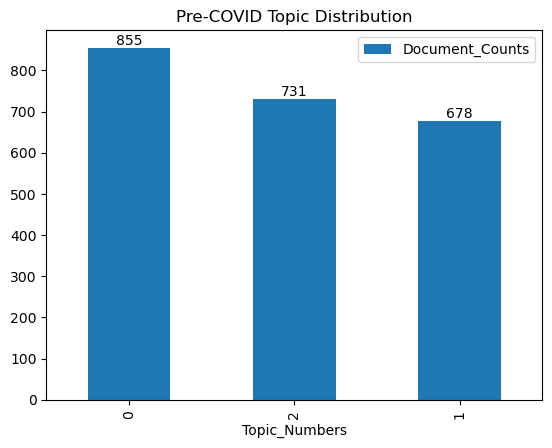

In [76]:
ax = pre_dist.plot.bar(x='Topic_Numbers', y='Document_Counts', title='Pre-COVID Topic Distribution')
ax.bar_label(ax.containers[0])

All the topics have almost equal distribution. No major activity of company is observed.

### Post-COVID

In [77]:
post_df_topic_sents_keywords = processor.dominant_topics(
   ldamodel=post_final_lda_model, corpus=post_corpus, texts=post_df['bigram'].values.tolist(), tweets=post_df['tweet'].values.tolist()
)

In [78]:
post_df_topic_sents_keywords

,Dominant_Topic,Perc_Contribution,Topic_Keywords,Text
0,0,0.9711,"gold, buy, gold_loan, stock, today, good, mana...",#MuthootFinance\n\nGetting ready for next leg ...
1,1,0.9725,"gold_loan, help, loan, india, company, branch,...","On 7th November, 2020, Muthoot M. George Found..."
2,0,0.9006,"gold, buy, gold_loan, stock, today, good, mana...",@kuttrapali mam your view on escorts and mutho...
3,0,0.9463,"gold, buy, gold_loan, stock, today, good, mana...","HEG, Muthoot Finance, Maithan Alloys can offer..."
4,0,0.9456,"gold, buy, gold_loan, stock, today, good, mana...",Muthoot Finance Weekly Chart forming a contrac...
...,...,...,...,...
4754,1,0.5554,"gold_loan, help, loan, india, company, branch,...",Labour union strikes cost Kerala 19800 crore p...
4755,1,0.8937,"gold_loan, help, loan, india, company, branch,...",@Karnataka_DIPR Address opp to muthoot finance...
4756,1,0.9465,"gold_loan, help, loan, india, company, branch,...",Have you been thinking of starting your own ve...
4757,1,0.7853,"gold_loan, help, loan, india, company, branch,...",@TRILOKHNATH And the few that exist are being ...


In [79]:
post_df_topic_sents_keywords['Topic_Keywords'].unique()

array(['gold, buy, gold_loan, stock, today, good, manappuram, bank, target, stocks',
       'gold_loan, help, loan, india, company, branch, like, pay, mr, money'],
      dtype=object)

Topics that can be inferred are:

1. Topic Number: 0
   - Probable topic title: Stocks
   - Key terms: 'gold, buy, gold_loan, stock, today, good, manappuram, bank, target, stocks'

<br>

2. Topic Number: 1
   - Probable topic title: Customer Experience
   - Key terms: 'gold_loan, help, loan, india, company, branch, like, pay, mr, money'

In [81]:
post_dist, fig = processor.plot_topic_distribution(post_df_topic_sents_keywords)
fig.show()

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



[Text(0, 0, '3225'), Text(0, 0, '1534')]

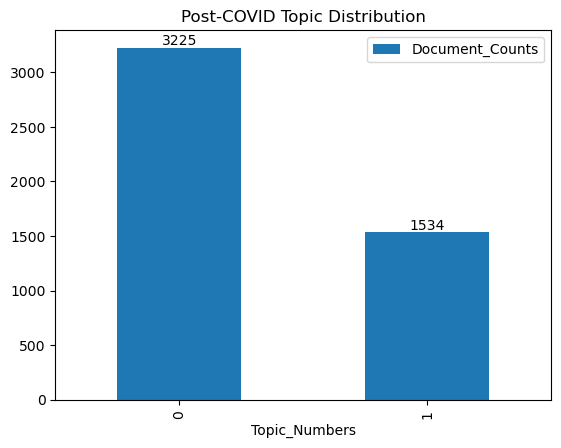

In [82]:
ax = post_dist.plot.bar(x='Topic_Numbers', y='Document_Counts', title='Post-COVID Topic Distribution')
ax.bar_label(ax.containers[0])

More and more people are trying to communicate with the company through Twitter.

In [43]:
# Save outputs
pre_df_topic_sents_keywords.to_csv('./../../data/nbfc/muthoot_finance/muthoot_finance_pre_output.csv', index=True)
post_df_topic_sents_keywords.to_csv('./../../data/nbfc/muthoot_finance/muthoot_finance_post_output.csv', index=True)